<a href="https://colab.research.google.com/github/markkod/pc3-enzymes/blob/exploratory_da/Copy_of_generate_kernels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#preinstalled version of pytorch has to be the same as the pre-compiled versions of the pytorch-geometric packages that we download later on.
#versions might change quickly, so if you get a strange error later on, check the torch version of Google colab later on as follows:

import torch
torch.__version__

'1.7.0+cu101'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Script to generate variations of the kernels yourself
# https://ucloud.univie.ac.at/index.php/s/E3YKph0jkpbw8TN


# #Download the TUDataset Repository with
!git clone https://github.com/chrsmrrs/tudataset.git
# #move this script to tudataset/tud_benchmark

# #Install pytorch geometric: https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html
# #Here is the gpu cuda installation, for the cpu version replace cu102 with cpu
%pip --no-cache-dir install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
%pip --no-cache-dir install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
%pip --no-cache-dir install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
%pip --no-cache-dir install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
%pip --no-cache-dir install torch-geometric

%pip --no-cache-dir install pybind11
!sudo apt-get install libeigen3-dev



fatal: destination path 'tudataset' already exists and is not an empty directory.
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 11.9MB 44.9MB/s 
  Found existing installation: torch-scatter 2.0.5
    Uninstalling torch-scatter-2.0.5:
      Successfully uninstalled torch-scatter-2.0.5
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 24.3MB 1.3MB/s 
  Found existing installation: torch-sparse 0.6.8
    Uninstalling torch-sparse-0.6.8:
      Successfully uninstalled torch-sparse-0.6.8
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 21.5MB 1.2MB/s 
  Found existing installation: torch-cluster 1.5.8
    Uninstalling torch-cluster-1.5.8:
      Successfully uninstalled torch-cluster-1.5.8
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 6.4MB 47.1MB/s 


In [4]:
%cd ..
%cd /content/tudataset/tud_benchmark/kernel_baselines/
! ls
! g++ -I /usr/include/eigen3 -O3 -shared -std=c++11 -fPIC `python3 -m pybind11 --includes`  kernel_baselines.cpp src/*cpp -o ../kernel_baselines`python3-config --extension-suffix`
%cd ..

/
/content/tudataset/tud_benchmark/kernel_baselines
kernel_baselines.cpp  src
/content/tudataset/tud_benchmark


In [5]:
!ls -al /usr/local/cuda

lrwxrwxrwx 1 root root 9 Dec 21 17:24 /usr/local/cuda -> cuda-10.1


In [6]:
import os
import torch
import numpy as np
import kernel_baselines as kb
import auxiliarymethods
from auxiliarymethods import datasets as dp
from scipy.sparse import save_npz
from scipy.sparse import load_npz
from auxiliarymethods import auxiliary_methods as aux
from auxiliarymethods import kernel_evaluation as ke
from auxiliarymethods.reader import tud_to_networkx
from matplotlib import pyplot as plt
import networkx as nx
from collections import defaultdict

In [7]:
def setup_directory(dir_name, verbose=False):
    """
    Setup directory in case it does not exist
    Parameters:
    -------------
    dir_name: str, path + name to directory
    verbose: bool, indicates whether directory creation should be printed or not.
    """
    if not os.path.exists(dir_name):
        try:
            os.makedirs(dir_name)
            if verbose:
                print("Created Directory: {}".format(dir_name))
        except Exception as e:
            raise RuntimeError(
                "Could not create directory: {}\n {}".format(dir_name, e))


In [8]:
use_edge_labels = False
for USE_LABELS in [True, False]:# Except IMDB-BINARY
    for dataset, use_labels in [["ENZYMES", USE_LABELS]]:
        if use_labels:
            base_path = os.path.join("kernels","node_labels")
        else:
            base_path = os.path.join("kernels","without_labels")
        setup_directory(base_path)
        print("Start processing data set ", dataset)
        # Download dataset.
        classes = dp.get_dataset(dataset)
        # *Weisfeihler-Lehman*
        print("Start computing Weisfeihler-Lehman gram matrix and vector representations")
        iterations = 9
        #0 taking just the nodelabels themselves into account; 
        #1 considers nearest-neighbours, 2 one layer deeper and so on
        for i in range(1, iterations):
            print("Start iteration ", i)
            #Gram Matrix for the Weisfeiler-Lehman subtree kernel
            gram_matrix_wl = kb.compute_wl_1_dense(dataset, i, use_labels, use_edge_labels)
            np.savetxt(os.path.join(base_path,f"{dataset}_gram_matrix_wl{i}.csv"),
                    gram_matrix_wl,
                    delimiter=";")
            #Sparse Vectors for the Weisfeiler-Lehmann subtree kernel
            vectors_wl = kb.compute_wl_1_sparse(dataset, i, use_labels, use_edge_labels)
            save_npz(os.path.join(base_path,f"{dataset}_vectors_wl{i}.npz"),
                    vectors_wl, compressed=True)

        # *Graphlet kernel*
        print("Start computing Graphlet gram matrix")

        #Gram Matrix for the Graphlet kernel
        gram_matrix_graphlet= kb.compute_graphlet_dense(dataset, use_labels, use_edge_labels)
        np.savetxt(os.path.join(base_path,f"{dataset}_gram_matrix_graphlet.csv"),
                gram_matrix_graphlet,
                delimiter=";")

        print("Start computing Graphlet vector representation")
        #Sparse Vectors for the Graphlet kernel
        vectors_graphlet = kb.compute_graphlet_sparse(dataset, use_labels, use_edge_labels)
        save_npz(os.path.join(base_path,f"{dataset}_vectors_graphlet.npz"),
                vectors_graphlet, compressed=True)


        print("Start computing Shortest path gram matrix")

        #Gram Matrix for the Shortest path kernel
        gram_matrix_shortestpath = kb.compute_shortestpath_dense(dataset, use_labels)
        np.savetxt(os.path.join(base_path,f"{dataset}_gram_matrix_shortestpath.csv"),
                gram_matrix_shortestpath,
                delimiter=";")

        print("Start computing Shortest path vector representation")

        #Sparse Vectors for the Shortest path kernel
        vectors_shortestpath = kb.compute_shortestpath_sparse(dataset, use_labels)
        save_npz(os.path.join(base_path,f"{dataset}_vectors_shortestpath.npz"),
                vectors_shortestpath, compressed=True)



Start processing data set  ENZYMES
Start computing Weisfeihler-Lehman gram matrix and vector representations
Start iteration  1
Start iteration  2
Start iteration  3
Start iteration  4
Start iteration  5
Start iteration  6
Start iteration  7
Start iteration  8
Start computing Graphlet gram matrix
Start computing Graphlet vector representation
Start computing Shortest path gram matrix
Start computing Shortest path vector representation
Start processing data set  ENZYMES
Start computing Weisfeihler-Lehman gram matrix and vector representations
Start iteration  1
Start iteration  2
Start iteration  3
Start iteration  4
Start iteration  5
Start iteration  6
Start iteration  7
Start iteration  8
Start computing Graphlet gram matrix
Start computing Graphlet vector representation
Start computing Shortest path gram matrix
Start computing Shortest path vector representation


In [9]:
def load_csv(path):
    return np.loadtxt(path, delimiter=";")

def load_sparse(path):
    return load_npz(path)

def select_from_list(l, indices):
    return [l[i] for i in indices]

In [10]:
def visualize(G, color=None, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, 
                     pos=nx.spring_layout(G, seed=42),
                     with_labels=True,
                     node_color=color,
                     cmap="Set2")
    plt.show()

In [11]:
base_path = os.path.join("kernels", "node_labels")
ds_name = "ENZYMES"
classes = dp.get_dataset(ds_name)
G = tud_to_networkx(ds_name)
print(f"Number of graphs in data set is {len(G)}")
print(f"Number of classes {len(set(classes.tolist()))}")

Number of graphs in data set is 600
Number of classes 6


In [12]:
def graph_list_properties(graphs, property):
  values = []
  for g in graphs:
    values.append(property(g))
  return values

In [13]:
print(G[0].nodes[0])

{'labels': [1], 'attributes': [11.0, 15.887014, 37.78, -0.51, 1.701, 93.9, 4.0, 5.0, 2.0, 4.0, 4.0, 3.0, 3.0, 4.0, 4.0, 3.0, 6.0, 2.0]}


In [14]:
print(G[0].nodes[0])
labels = set()
for g in G:
  for i in range(g.number_of_nodes()):
    labels.add(g.nodes[i]["labels"][0])
labels

{'labels': [1], 'attributes': [11.0, 15.887014, 37.78, -0.51, 1.701, 93.9, 4.0, 5.0, 2.0, 4.0, 4.0, 3.0, 3.0, 4.0, 4.0, 3.0, 6.0, 2.0]}


{1, 2, 3}

Num nodes:
6 [37, 23, 25, 24, 23, 24, 26, 88, 23, 32, 4, 14, 42, 41, 36, 55, 40, 38, 2, 35, 42, 41, 39, 42, 41, 40, 37, 23, 22, 34, 38, 38, 39, 8, 23, 42, 42, 100, 24, 24, 47, 45, 45, 45, 46, 44, 30, 32, 33, 9, 27, 39, 16, 18, 7, 18, 10, 21, 18, 10, 9, 39, 33, 29, 24, 25, 30, 38, 28, 28, 38, 40, 40, 42, 20, 19, 16, 17, 20, 18, 33, 23, 23, 35, 33, 39, 40, 38, 40, 38, 37, 36, 34, 34, 32, 18, 32, 34, 30, 5]

Cliques:
6 3026.1958762886597 [3316.0, 865.0, 1388.0, 1308.0, 975.0, 1169.0, 1071.0, 30099.0, 1295.0, 3599.0, 6.0, 229.0, 7371.0, 7034.0, 4579.0, 7157.0, 3189.0, 2861.0, 1.0, 3374.0, 5345.0, 5067.0, 4501.0, 5106.0, 4811.0, 4887.0, 3729.0, 805.0, 814.0, 3468.0, 3076.0, 3075.0, 3563.0, 48.0, 1115.0, 4619.0, 4649.0, inf, 1290.0, 956.0, 5645.0, 5490.0, 5512.0, 5512.0, 5744.0, 5112.0, 2849.0, 3125.0, 3304.0, 77.0, 1209.0, inf, 313.0, 470.0, 30.0, 450.0, 92.0, 641.0, 424.0, 92.0, 72.0, 5927.0, 3867.0, 2623.0, 1511.0, 1573.0, 2707.0, 3795.0, 1754.0, 2027.0, 2819.0, 6372.0, 4738.0, 5322.0, 81

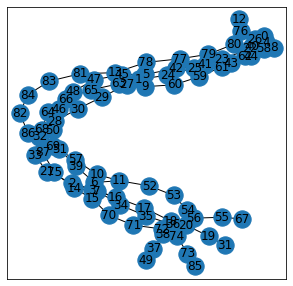

88

In [15]:
graph_dict = defaultdict(list)
for i, g in enumerate(G):
  graph_dict[classes[i]].append(g)

for label_class in graph_dict:
  print("Num nodes:")
  num_nodes = graph_list_properties(graph_dict[label_class], lambda g: g.number_of_nodes())
  print(label_class, num_nodes)

  print()
  print("Cliques:")
  num_nodes = graph_list_properties(graph_dict[label_class], lambda g: nx.algorithms.wiener_index(g))
  print(label_class, np.average(np.array([n for n in num_nodes if str(n) != "inf"])), num_nodes)
  print()
  print()

visualize(graph_dict[6][7])
graph_dict[6][7].number_of_nodes()

In [16]:
def find_keys_with_condition(data, cond):
    return list(filter(lambda x: cond in x, data.keys()))

def load_data():
  result = {}
  extensions = ['csv', 'npz']
  types = ['gram_matrix', 'vectors']
  algos = ['wl1', 'wl2', 'wl3', 'wl4', 'wl5', 'wl6', 'wl7', 'wl8', 'shortestpath', 'graphlet']
  base_name = '/content/tudataset/tud_benchmark/kernels/node_labels/ENZYMES_{0}_{1}.{2}'

  for t, e in zip(types, extensions):
    result[t] = {}
    for a in algos:
      algo_name = 'wl' if 'wl' in a else a

      if algo_name not in result[t].keys():
        result[t][algo_name] = []

      file_name = base_name.format(t, a, e)

      if e == 'csv':
        f = np.loadtxt(file_name, delimiter=';')
      else:
        f = load_npz(file_name)
      
      result[t][algo_name].append(f)
  return result

In [17]:
data = load_data()
data

{'gram_matrix': {'graphlet': [array([[11177.,  6596.,  4333., ..., 11081., 13908., 10164.],
          [ 6596.,  4879.,  3005., ...,  4882.,  5786.,  3278.],
          [ 4333.,  3005.,  2132., ...,  2814.,  3236.,  1674.],
          ...,
          [11081.,  4882.,  2814., ..., 20397., 22060., 18291.],
          [13908.,  5786.,  3236., ..., 22060., 28850., 24883.],
          [10164.,  3278.,  1674., ..., 18291., 24883., 22359.]])],
  'shortestpath': [array([[ 73924.,  30546.,  35514., ...,  79166., 117398.,  96672.],
          [ 30546.,  15744.,  16882., ...,  36894.,  56388.,  46384.],
          [ 35514.,  16882.,  21316., ...,  33136.,  54940.,  44536.],
          ...,
          [ 79166.,  36894.,  33136., ..., 316796., 227164., 199264.],
          [117398.,  56388.,  54940., ..., 227164., 337252., 289668.],
          [ 96672.,  46384.,  44536., ..., 199264., 289668., 256200.]])],
  'wl': [array([[ 874.,  502.,  585., ...,  973.,  998.,  935.],
          [ 502.,  360.,  362., ...,  59

In [18]:
def eval_kernel(kernel, classes, mode, n_reps=10, all_std=True):
  normalized = []
  print(f'Starting normalization of {len(kernel)} elements...')
  for array in kernel:
    if mode == 'LINEAR':
      normalized.append(aux.normalize_feature_vector(array))
    else:
      normalized.append(aux.normalize_gram_matrix(array))
  print(f'Normalization finished, starting {mode} SVM...')
  if mode == 'LINEAR':
    return ke.linear_svm_evaluation(normalized, classes, num_repetitions=n_reps, all_std=all_std)
  return ke.kernel_svm_evaluation(normalized, classes, num_repetitions=n_reps, all_std=all_std)

def eval_all(data):
  classes = dp.get_dataset('ENZYMES')
  result = {}
  for data_type in data.keys():
    mode = 'LINEAR' if data_type == 'vectors' else 'KERNEL'
    result[data_type] = {}
    print('MODE:', mode)
    for kernel in data[data_type]:
      print(f'\nEvaluating {kernel} SVM...')
      result[data_type][kernel] = eval_kernel(data[data_type][kernel], classes, mode)
      print(f'{data_type}-{kernel} : {result[data_type][kernel]}')
  return result



In [19]:
#for array in data["gram_matrix"]["wl"]:
#  normalized = [aux.normalize_gram_matrix(array)]
#  print(ke.kernel_svm_evaluation(normalized, classes, num_repetitions=10, all_std=True))

In [20]:
type(data["vectors"]["shortestpath"][0])

scipy.sparse.csc.csc_matrix

In [ ]:
val = data["vectors"]["wl"][2].T.dot(data["vectors"]["shortestpath"][0])
print(1)
normalized = [aux.normalize_feature_vector(val)]
print(2)
print(ke.linear_svm_evaluation(normalized, classes, num_repetitions=10, all_std=True))


In [22]:
#eval_all(data)